In [79]:
from IPython.display import HTML

In [80]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

This object detection notebook searches for people within the image, then cropps bounding boxes around them and saves into a folder. The cropped images can be further fed into the same model to specifically look for ties and handbags or to another model that has an apparel detection focus.

# Imports

In [89]:
import datetime
import numpy as np
import os
import six.moves.urllib as urllib
import sys

sys.path.append('../../../visual-object-identifier/opencv_demo')
import streamclass as sc

import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


## Env setup

In [90]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [91]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [92]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

In [93]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

In [94]:
#different model example:
#http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18.tar.gz

## Load a (frozen) Tensorflow model into memory.

In [95]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [96]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [97]:
print (categories [0])
print (categories [27]) 
print (len(categories))

{'name': 'person', 'id': 1}
{'name': 'tie', 'id': 32}
80


## Helper code

In [98]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [109]:
#This path is pointing to images to be tested 
PATH_TO_TEST_IMAGES_DIR = 'test_images'
#This path is pointing to folder to store cropped boxes 
path_to_boxes = 'cropped_boxes'

# Size, in inches, of the output images.
IMAGE_SIZE = (16, 12)

In [110]:
TEST_IMAGE_PATHS = []
for root, dirs, files in os.walk(PATH_TO_TEST_IMAGES_DIR):
    for file in files:
        TEST_IMAGE_PATHS.append(PATH_TO_TEST_IMAGES_DIR +'/'+ file)

#getting rid of an .DS_Store file in each of the Mac folders
TEST_IMAGE_PATHS= TEST_IMAGE_PATHS[1 :]
print (TEST_IMAGE_PATHS)

['test_images/friends.jpg', 'test_images/leo_in_tie.jpg', 'test_images/Men_in_ties.jpg', 'test_images/wedding.jpg', 'test_images/women.jpg']


In [111]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
                ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                      tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                          tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [112]:
def get_file_name_and_type (file_path):
    seperated_by_slash = file_path.split('/')
    whole_file_name = seperated_by_slash [-1]
    seperated_by_dot = whole_file_name.split('.')
    file_name = seperated_by_dot[0] 
    file_extention = seperated_by_dot[1]
    return file_name, file_extention

In [113]:
#this function stores cropped boxes from a single image. 
#They are named by the numer of the image in folder - n and then 1,2,3 etc. 
def save_cropped_boxes_for_image(image, list_of_labels, list_of_coordinates, file_name, file_extention):
    boxes_to_crop = []
    for i in range (len(labels_list)) :
        if labels_list[i]=='person':
            boxes_to_crop.append(coordiantes_list[i])
    
    for box_number in range (len(boxes_to_crop)):
        width = image.size[0]
        height = image.size[1]
        #coordinates mis-match fixing for cropping
        coordinates = [boxes_to_crop[box_number][1]*width, boxes_to_crop[box_number][0]*height, 
                       boxes_to_crop[box_number][3]*width, boxes_to_crop[box_number][2]*height]
        img = image.crop(coordinates)
        time_stamp = datetime.datetime.today().strftime('%Y%m%d')
        save_image_paths = os.path.join(path_to_boxes, '{}_person{}_{}.{}'.format(file_name, box_number, time_stamp, file_extention))
        img.save(save_image_paths, 'JPEG')

CPU times: user 35.8 s, sys: 6.82 s, total: 42.6 s
Wall time: 41.9 s


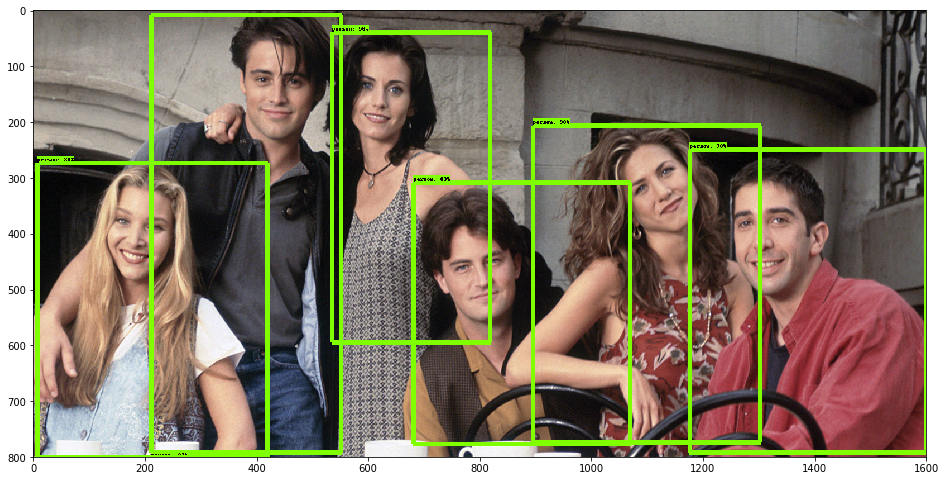

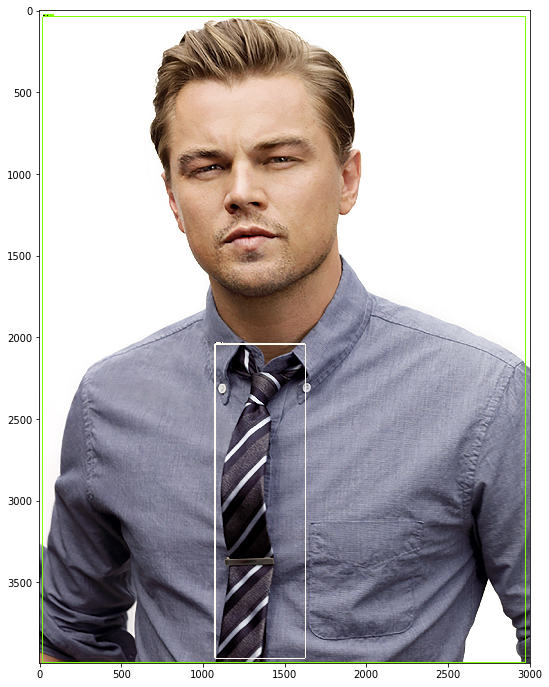

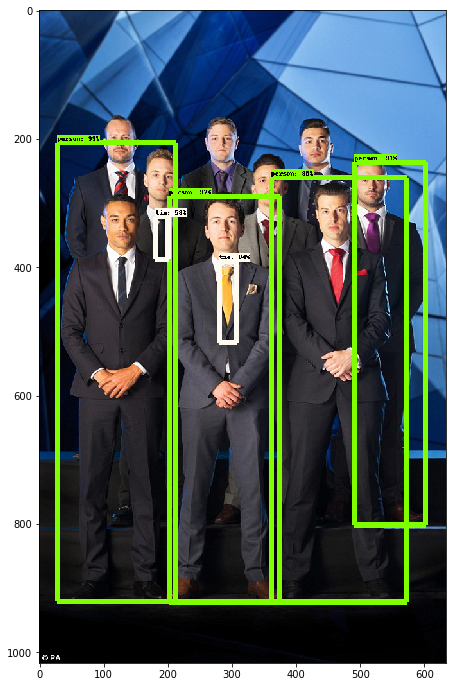

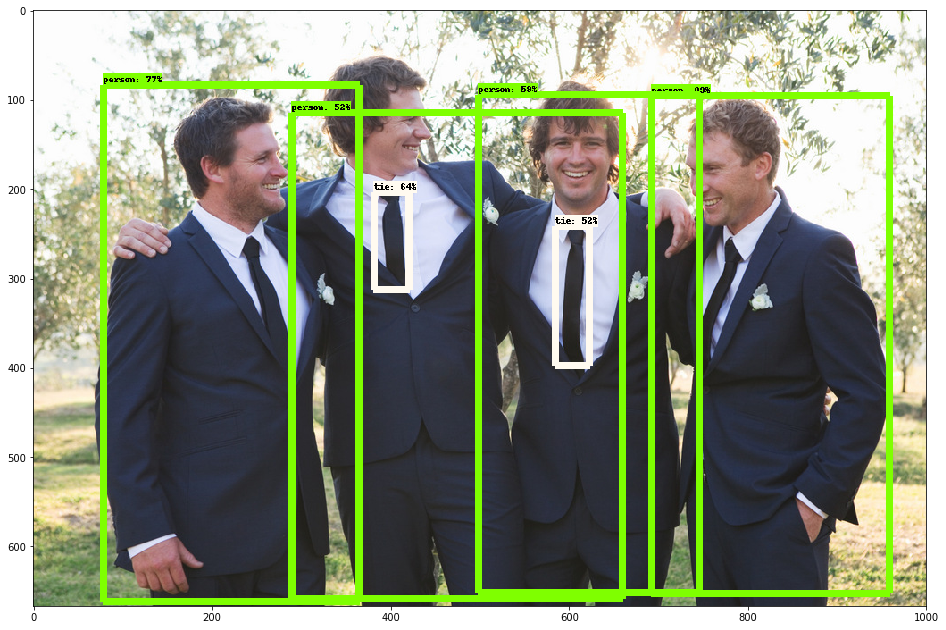

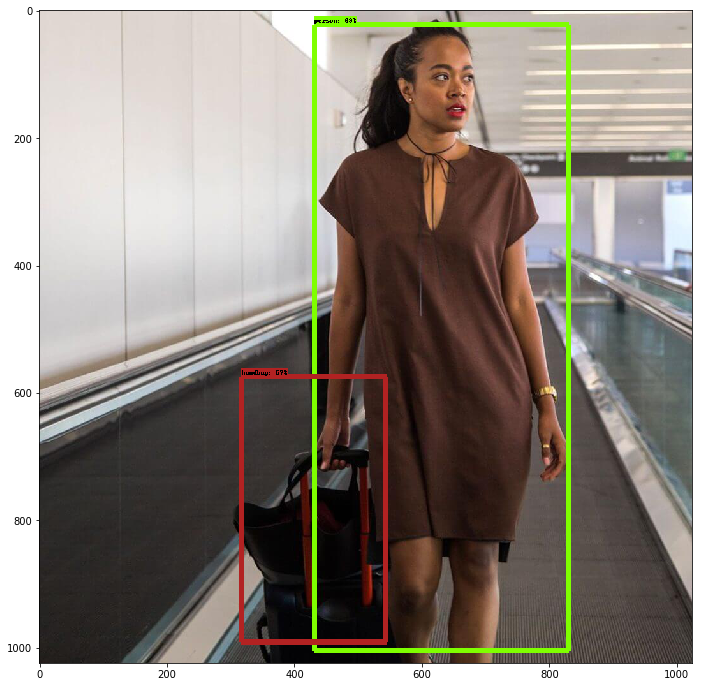

In [114]:
%%time
#This function takes about 5s for a single image to be analysed 
n=1
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
    image_array, labels_list, scores_list, coordiantes_list = (vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8))
    #saving cropped boxes here
    file_name, file_extention = get_file_name_and_type(image_path)
    save_images = save_cropped_boxes_for_image(image, labels_list, coordiantes_list, file_name, file_extention)
    n= n+1
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

Let's run the cropped people boxes through the same model to find ties? Will that have a better accuracy?

In [115]:
PATH_TO_CROPPED = 'cropped_boxes'

In [117]:
TEST_FOR_TIES = []
for root, dirs, files in os.walk(PATH_TO_CROPPED):
    for file in files:
        TEST_FOR_TIES.append(PATH_TO_CROPPED +'/'+ file)
        
TEST_FOR_TIES= TEST_FOR_TIES[1 :]
print (TEST_FOR_TIES)

['cropped_boxes/friends_person0_20180803.jpg', 'cropped_boxes/friends_person1_20180803.jpg', 'cropped_boxes/friends_person2_20180803.jpg', 'cropped_boxes/friends_person3_20180803.jpg', 'cropped_boxes/friends_person4_20180803.jpg', 'cropped_boxes/friends_person5_20180803.jpg', 'cropped_boxes/leo_in_tie_person0_20180803.jpg', 'cropped_boxes/Men_in_ties_person0_20180803.jpg', 'cropped_boxes/Men_in_ties_person1_20180803.jpg', 'cropped_boxes/Men_in_ties_person2_20180803.jpg', 'cropped_boxes/Men_in_ties_person3_20180803.jpg', 'cropped_boxes/wedding_person0_20180803.jpg', 'cropped_boxes/wedding_person1_20180803.jpg', 'cropped_boxes/wedding_person2_20180803.jpg', 'cropped_boxes/wedding_person3_20180803.jpg', 'cropped_boxes/women_person0_20180803.jpg']


CPU times: user 1min 12s, sys: 13.3 s, total: 1min 26s
Wall time: 1min 26s


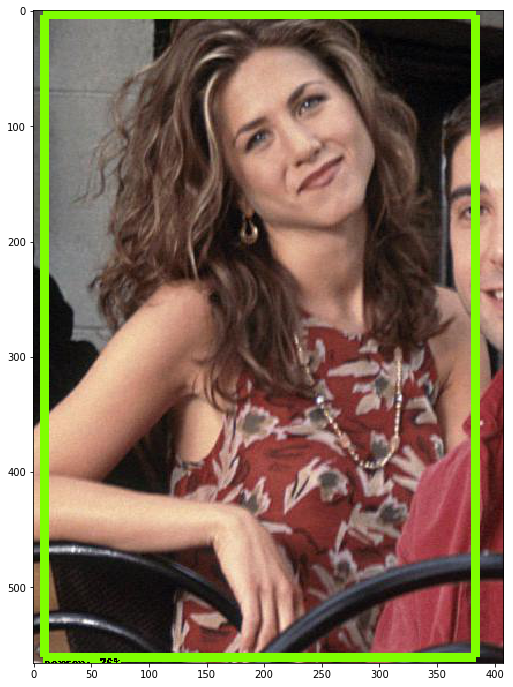

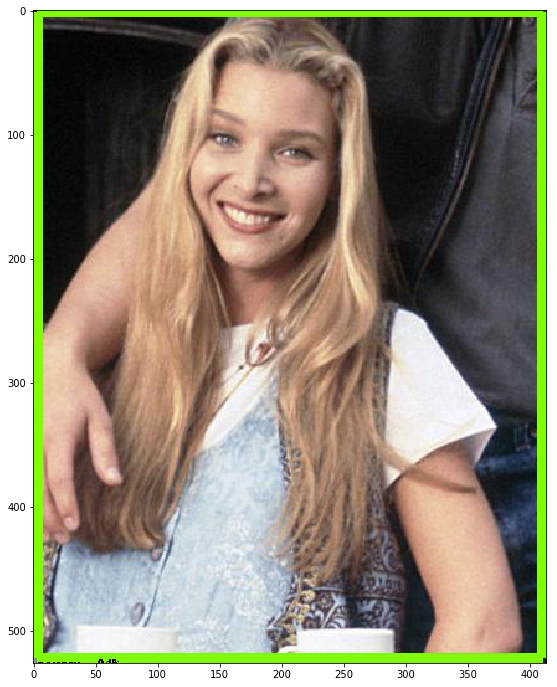

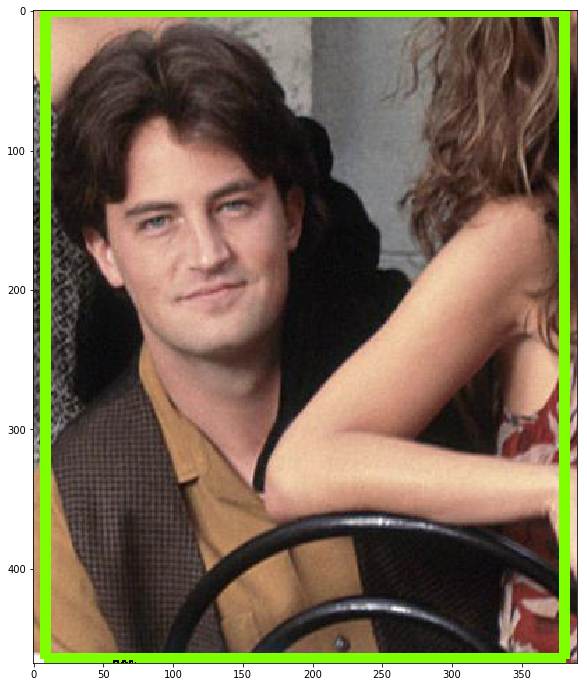

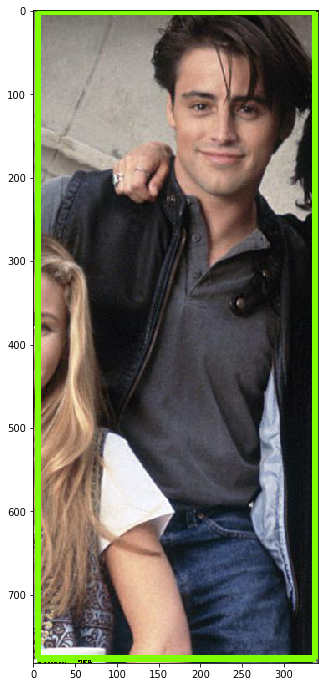

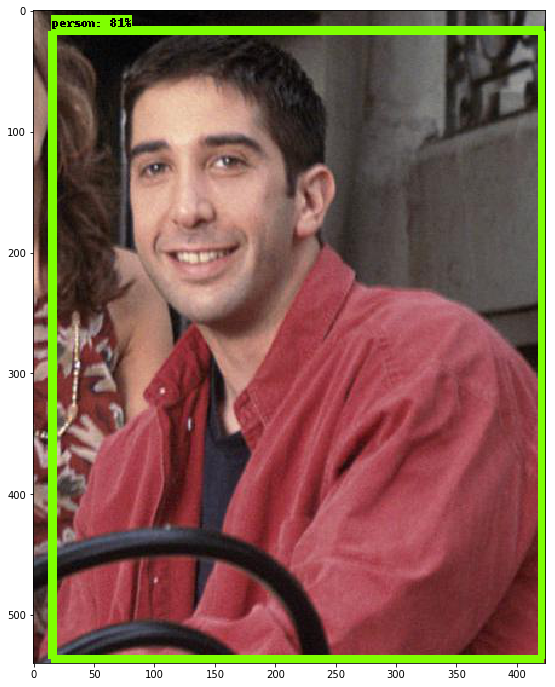

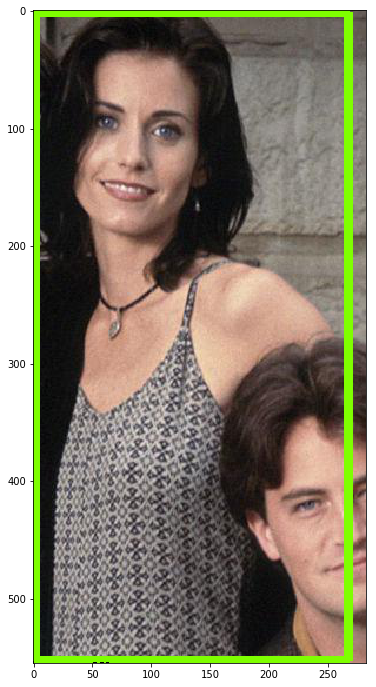

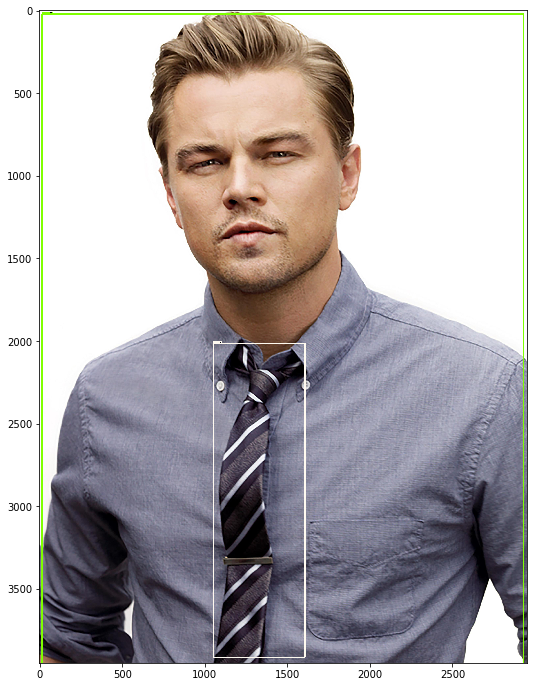

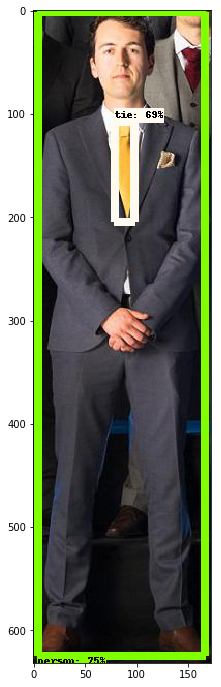

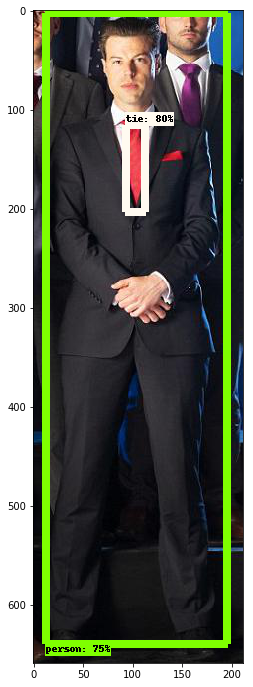

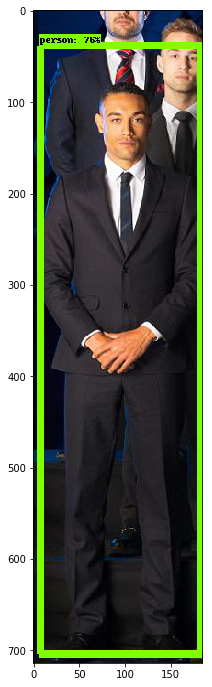

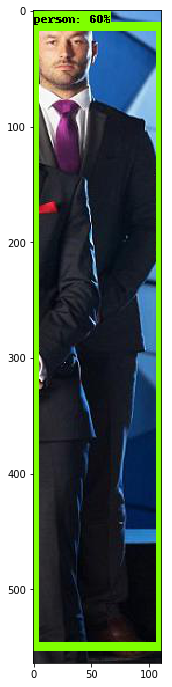

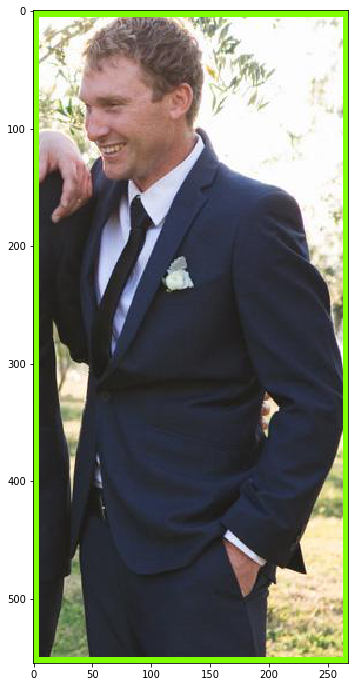

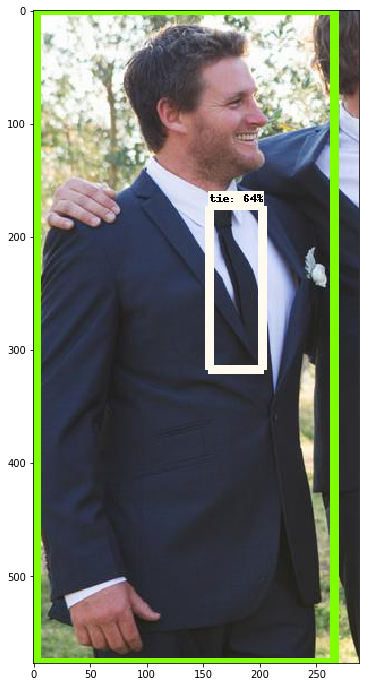

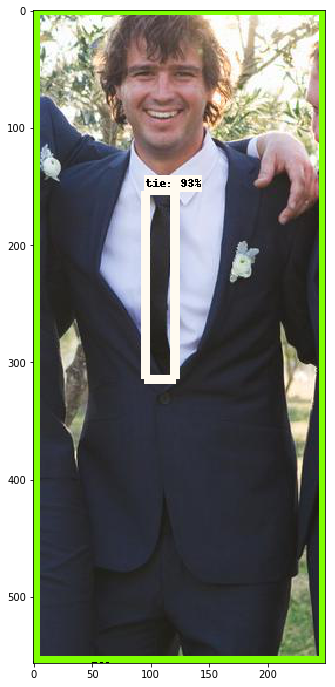

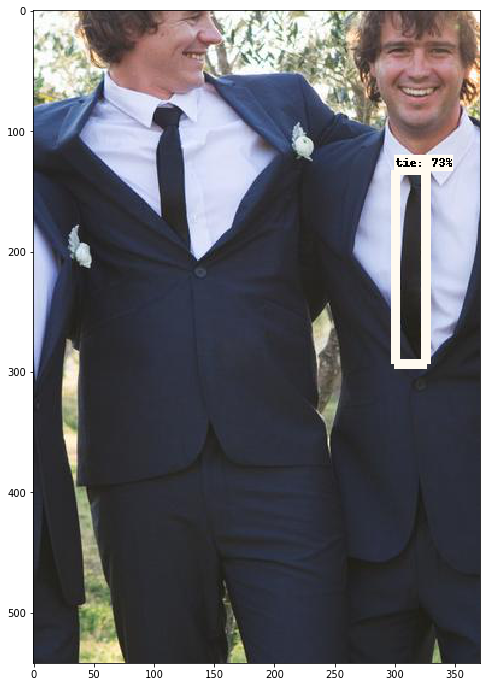

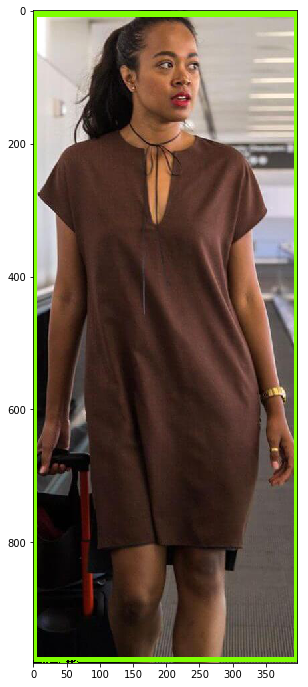

In [118]:
%%time
#This function takes about 5s for a single image to be analysed 
n=1
for image_path in TEST_FOR_TIES:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
    image_array, labels_list, scores_list, coordiantes_list = (vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8))
    #saving cropped boxes here
    file_name, file_extention = get_file_name_and_type(image_path)
    n= n+1
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)